In [ ]:
# 30个频率频道 116*116输入   3种不同3dcnn模型的对比  

In [ ]:
# !pip install import-ipynb
# import import_ipynb

%tensorflow_version 2.x
# !pip install numpy==1.16.1

# 初始化

In [1]:

import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.metrics import r2_score, accuracy_score
import matplotlib.pyplot as plt 
from keras.models import Model, Sequential
from keras.layers import Conv1D,Flatten,Conv2D, Dropout, MaxPooling2D, Input,Conv3D, MaxPooling3D, Dense, BatchNormalization, AveragePooling3D
from keras import Input,layers
from keras.layers.merge import concatenate 
from google.colab import drive
from keras.optimizers import Adam,RMSprop,SGD
from keras.wrappers.scikit_learn import KerasClassifier,KerasRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
drive.mount('/content/drive')
# %cp -av fromfolder tofolder
# %cd "/content/drive/My Drive/Newdata/"
# from model_functions import *

Mounted at /content/drive


# 载入数据

# flipped  30hz  不带control(3600)  3percentage

In [ ]:
patient_order = range(1,25)
order = shuffle(patient_order, random_state = 10)
print(patient_order)
print(order)  
# [14, 18, 20, 5, 2, 22, 19, 15, 23, 17, 24, 13, 11, 6, 9, 7, 1, 3, 8, 12, 21, 10, 16, 4]    random_state =20 
# [6, 2, 8, 3, 12, 13, 22, 14, 15, 4, 23, 7, 19, 11, 21, 24, 9, 20, 17, 18, 1, 16, 5, 10]    random_state =10

tmp = order[0]
A = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/connectivity/nonflipped_keep30_150_' + str(tmp)+ '.npy',allow_pickle=True)
A = np.reshape(A,(150,30,116,116))
for i in order[1:20]: 
  a = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/connectivity/nonflipped_keep30_150_' + str(i)+ '.npy',allow_pickle=True)
  a = np.reshape(a,(150,30,116,116))
  A = np.concatenate((A,a), axis = 0)
print(A.shape)
# 前十八个 病人数据做训练data(2700, 30, 116,116)


tmp = order[0]
B = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/4/output_150_4_' + str(tmp)+ '.npy',allow_pickle=True)
for i in order[1:20]: 
  b = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/4/output_150_4_' + str(i)+ '.npy',allow_pickle=True)
  B = np.concatenate((B,b), axis = 0)
print(B.shape)
# 前十八个 病人数据做训练label(2700, 4)

tmp = order[20]
C = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/connectivity/nonflipped_keep30_150_' + str(tmp)+ '.npy',allow_pickle=True)
C = np.reshape(C,(150,30,116,116))
for i in order[21:]: 
  c = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/connectivity/nonflipped_keep30_150_' + str(i)+ '.npy',allow_pickle=True)
  c = np.reshape(c,(150,30,116,116))
  C = np.concatenate((C,c), axis = 0)
print(C.shape)
# 后六个人 病人数据做测试data(900, 30, 116,116)

tmp = order[20]
D = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/4/output_150_4_' + str(tmp)+ '.npy',allow_pickle=True)
for i in order[21:]: 
  d = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/4/output_150_4_' + str(i)+ '.npy',allow_pickle=True)
  D = np.concatenate((D,d), axis = 0)
print(D.shape)
# 后六个人 病人数据做测试label(900, 4)

np.save('/content/drive/My Drive/Newdata/ordered_by_patient/non_filpped_train_data_3000_30_116_116', A)
np.save('/content/drive/My Drive/Newdata/ordered_by_patient/non_filpped_train_label_3000_2', B)
np.save('/content/drive/My Drive/Newdata/ordered_by_patient/non_filpped_test_data_600_30_116_116', C)
np.save('/content/drive/My Drive/Newdata/ordered_by_patient/non_filpped_test_label_600_2', D)


range(1, 25)
[6, 2, 8, 3, 12, 13, 22, 14, 15, 4, 23, 7, 19, 11, 21, 24, 9, 20, 17, 18, 1, 16, 5, 10]
(3000, 30, 116, 116)
(3000, 4)
(600, 30, 116, 116)
(600, 4)


In [2]:
# train_data = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/train_data_24_150_30_116_116.npy')
# label2 = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/train_label2_24_150_3.npy')
# label3 =  np.load('/content/drive/My Drive/Newdata/ordered_by_patient/train_label3_24_150_3.npy')
# test_label = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/test_label_600_3.npy')

train_data = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/non_filpped_train_data_3000_30_116_116.npy')
train_label = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/non_filpped_train_label_3000_2.npy',allow_pickle= True)
test_data = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/non_filpped_test_data_600_30_116_116.npy')
test_label = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/non_filpped_test_label_600_2.npy', allow_pickle= True)

train_data = np.reshape(train_data,(3000,30,116,116,1))
test_data = np.reshape(test_data,(600,30,116,116,1)) 

train_data, train_label = shuffle(train_data,train_label, random_state =10)


In [3]:
train_label = np.array(train_label, dtype=np.float)
test_label = np.array(test_label, dtype=np.float)

In [4]:
print(train_data.shape)

(3000, 30, 116, 116, 1)


#可视化

In [ ]:
# model = '/content/drive/My Drive/Colab Notebooks/weight/3dcnn_distribution.h5'
# from tensorflow.keras.models import load_model
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/weight/3dcnn_distribution1.h5')
model0 = Model(inputs = model.inputs, outputs = model.layers[0].output)
model3 = Model(inputs = model.inputs, outputs = model.layers[3].output)
model6 = Model(inputs = model.inputs, outputs = model.layers[6].output)
model9 = Model(inputs = model.inputs, outputs = model.layers[9].output)
model12 = Model(inputs = model.inputs, outputs = model.layers[12].output)
model16 = Model(inputs = model.inputs, outputs = model.layers[16].output)
model20 = Model(inputs = model.inputs, outputs = model.layers[20].output)
# model1 = Model(inputs=model.inputs, outputs=model.layers[0].outputs)  # 0,4,8(16,32,16)
# 0,3,6,9,12,16,20
# model1.summary()
# load the image with the required shape

img=test_data[300:301]
# print(img.shape)
feature_maps0 = model0.predict(img)
feature_maps3 = model3.predict(img)
feature_maps6 = model6.predict(img)
feature_maps9 = model9.predict(img)
feature_maps12 = model12.predict(img)
feature_maps16 = model16.predict(img)
feature_maps20 = model20.predict(img)
# plot all 16 maps in an 4x4 squares
# print(feature_maps8.shape)
# square = 4
# ix = 1


In [ ]:
i = 3
plt.figure(figsize=(5,5))
plt.imshow(img[0,0,:,:,0])
# plt.show()
plt.savefig('/content/drive/My Drive/images/featuremaps/'+ str(i)+ '0.png',dpi = 800)

plt.figure(figsize=(5,5))
plt.imshow(feature_maps0[0,0,:,:,0])
# plt.show()
plt.savefig('/content/drive/My Drive/images/featuremaps/'+ str(i)+ '1.png',dpi = 800)

plt.figure(figsize=(5,5))
plt.imshow(feature_maps3[0,0,:,:,0])
# plt.show()
plt.savefig('/content/drive/My Drive/images/featuremaps/'+ str(i)+ '2.png',dpi = 800)

plt.figure(figsize=(5,5))
plt.imshow(feature_maps6[0,0,:,:,0])
# plt.show()
plt.savefig('/content/drive/My Drive/images/featuremaps/'+ str(i)+ '3.png',dpi = 800)


plt.figure(figsize=(5,5))
plt.imshow(feature_maps9[0,0,:,:,0])
# plt.show()
plt.savefig('/content/drive/My Drive/images/featuremaps/'+ str(i)+ '4.png',dpi = 800)

plt.figure(figsize=(5,5))
plt.imshow(feature_maps12[0,0,:,:,0])
# plt.show()
plt.savefig('/content/drive/My Drive/images/featuremaps/'+ str(i)+ '5.png',dpi = 800)

plt.figure(figsize=(5,5))
plt.imshow(feature_maps16[0,0,:,:,0])
# plt.show()
plt.savefig('/content/drive/My Drive/images/featuremaps/'+ str(i)+ '6.png',dpi = 800)

plt.figure(figsize=(5,5))
plt.imshow(feature_maps20[0,0,:,:,0])
# plt.show()
plt.savefig('/content/drive/My Drive/images/featuremaps/'+ str(i)+ '7.png',dpi = 800)

In [8]:
#原始数据展示 同一个病人不同数据

i = '10hz'
hz = 9
# img=test_data[0:1]
# plt.figure(figsize=(5,5))
# plt.imshow(img[0,hz,:,:,0])

# plt.savefig('/content/drive/My Drive/images/featuremaps/original'+ str(i)+ '0.png',dpi = 800)

# img=test_data[1:2]
# plt.figure(figsize=(5,5))
# plt.imshow(img[0,hz,:,:,0])

# plt.savefig('/content/drive/My Drive/images/featuremaps/original'+ str(i)+ '1.png',dpi = 800)

# img=test_data[2:3]
# plt.figure(figsize=(5,5))
# plt.imshow(img[0,hz,:,:,0])

# plt.savefig('/content/drive/My Drive/images/featuremaps/original'+ str(i)+ '2.png',dpi = 800)

# img=test_data[3:4]
# plt.figure(figsize=(5,5))
# plt.imshow(img[0,hz,:,:,0])

# plt.savefig('/content/drive/My Drive/images/featuremaps/original'+ str(i)+ '3.png',dpi = 800)

# img=test_data[4:5]
# plt.figure(figsize=(5,5))
# plt.imshow(img[0,hz,:,:,0])

# plt.savefig('/content/drive/My Drive/images/featuremaps/original'+ str(i)+ '4.png',dpi = 800)

# img=test_data[5:6]
# plt.figure(figsize=(5,5))
# plt.imshow(img[0,hz,:,:,0])

# plt.savefig('/content/drive/My Drive/images/featuremaps/original'+ str(i)+ '5.png',dpi = 800)

for j in range(50):
  img=test_data[j:j+1]
  plt.figure(figsize=(5,5))
  plt.imshow(img[0,hz,:,:,0])
  plt.savefig('/content/drive/My Drive/images/featuremaps/original'+ str(i)+ str(j) + '.png',dpi = 800)

Output hidden; open in https://colab.research.google.com to view.

# nonflipped全保留数据 不带control(150)  两个class

In [ ]:
patient_order = range(1,25)
order = shuffle(patient_order, random_state = 10)
print(patient_order)
print(order)  
# [14, 18, 20, 5, 2, 22, 19, 15, 23, 17, 24, 13, 11, 6, 9, 7, 1, 3, 8, 12, 21, 10, 16, 4]    random_state =20 
# [6, 2, 8, 3, 12, 13, 22, 14, 15, 4, 23, 7, 19, 11, 21, 24, 9, 20, 17, 18, 1, 16, 5, 10]    random_state =10

tmp = order[0]
A = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/connectivity/nonflipped_all_150_' + str(tmp)+ '.npy',allow_pickle=True)
A = np.reshape(A,(150,30,116,116))
for i in order[1:20]: 
  a = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/connectivity/nonflipped_all_150_' + str(i)+ '.npy',allow_pickle=True)
  a = np.reshape(a,(150,30,116,116))
  A = np.concatenate((A,a), axis = 0)
print(A.shape)
# 前十八个 病人数据做训练data(2700, 30, 116,116)


tmp = order[0]
B = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/4/output_150_4_' + str(tmp)+ '.npy',allow_pickle=True)
for i in order[1:20]: 
  b = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/4/output_150_4_' + str(i)+ '.npy',allow_pickle=True)
  B = np.concatenate((B,b), axis = 0)
print(B.shape)
# 前十八个 病人数据做训练label(2700, 4)

tmp = order[20]
C = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/connectivity/nonflipped_all_150_' + str(tmp)+ '.npy',allow_pickle=True)
C = np.reshape(C,(150,30,116,116))
for i in order[21:]: 
  c = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/connectivity/nonflipped_all_150_' + str(i)+ '.npy',allow_pickle=True)
  c = np.reshape(c,(150,30,116,116))
  C = np.concatenate((C,c), axis = 0)
print(C.shape)
# 后六个人 病人数据做测试data(900, 30, 116,116)

tmp = order[20]
D = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/4/output_150_4_' + str(tmp)+ '.npy',allow_pickle=True)
for i in order[21:]: 
  d = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/4/output_150_4_' + str(i)+ '.npy',allow_pickle=True)
  D = np.concatenate((D,d), axis = 0)
print(D.shape)
# 后六个人 病人数据做测试label(900, 4)

np.save('/content/drive/My Drive/Newdata/ordered_by_patient/train_data_2700_6_116_116_original', A)
np.save('/content/drive/My Drive/Newdata/ordered_by_patient/train_label_2700_25_3', B)
np.save('/content/drive/My Drive/Newdata/ordered_by_patient/test_data_900_6_116_116_original', C)
np.save('/content/drive/My Drive/Newdata/ordered_by_patient/test_label_900_25_3', D)

# train_data = A
# train_label = B
# test_data = C
# test_label = D

# train_data = np.reshape(train_data,(3000,30,116,116,1))
# test_data = np.reshape(test_data,(600,30,116,116,1)) 

# train_data, train_label = shuffle(train_data,train_label, random_state =10)

# print(train_data.shape)
# print(train_label.shape)
# print(test_data.shape)
# print(test_label.shape)

range(1, 25)
[6, 2, 8, 3, 12, 13, 22, 14, 15, 4, 23, 7, 19, 11, 21, 24, 9, 20, 17, 18, 1, 16, 5, 10]
(3000, 30, 116, 116)
(3000, 4)
(600, 30, 116, 116)
(600, 4)
(3000, 30, 116, 116, 1)
(3000, 4)
(600, 30, 116, 116, 1)
(600, 4)


# nonflipped keep30 不带control（150）两个class

In [ ]:
patient_order = range(1,25)
order = shuffle(patient_order, random_state = 10)
print(patient_order)
print(order)  
# [14, 18, 20, 5, 2, 22, 19, 15, 23, 17, 24, 13, 11, 6, 9, 7, 1, 3, 8, 12, 21, 10, 16, 4]    random_state =20 
# [6, 2, 8, 3, 12, 13, 22, 14, 15, 4, 23, 7, 19, 11, 21, 24, 9, 20, 17, 18, 1, 16, 5, 10]    random_state =10

tmp = order[0]
A = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/connectivity/nonflipped_keep30_150_' + str(tmp)+ '.npy',allow_pickle=True)
A = np.reshape(A,(150,30,116,116))
for i in order[1:18]: 
  a = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/connectivity/nonflipped_keep30_150_' + str(i)+ '.npy',allow_pickle=True)
  a = np.reshape(a,(150,30,116,116))
  A = np.concatenate((A,a), axis = 0)
print(A.shape)
# 前十八个 病人数据做训练data(2700, 30, 116,116)


tmp = order[0]
B = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/4/output_150_4_' + str(tmp)+ '.npy',allow_pickle=True)
for i in order[1:18]: 
  b = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/4/output_150_4_' + str(i)+ '.npy',allow_pickle=True)
  B = np.concatenate((B,b), axis = 0)
print(B.shape)
# 前十八个 病人数据做训练label(2700, 4)

tmp = order[18]
C = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/connectivity/nonflipped_keep30_150_' + str(tmp)+ '.npy',allow_pickle=True)
C = np.reshape(C,(150,30,116,116))
for i in order[19:]: 
  c = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/connectivity/nonflipped_keep30_150_' + str(i)+ '.npy',allow_pickle=True)
  c = np.reshape(c,(150,30,116,116))
  C = np.concatenate((C,c), axis = 0)
print(C.shape)
# 后六个人 病人数据做测试data(900, 30, 116,116)

tmp = order[18]
D = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/4/output_150_4_' + str(tmp)+ '.npy',allow_pickle=True)
for i in order[19:]: 
  d = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/4/output_150_4_' + str(i)+ '.npy',allow_pickle=True)
  D = np.concatenate((D,d), axis = 0)
print(D.shape)
# 后六个人 病人数据做测试label(900, 4)

# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/train_data_2700_6_116_116_original', A)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/train_label_2700_25_3', B)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/test_data_900_6_116_116_original', C)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/test_label_900_25_3', D)

train_data = A
train_label = B
test_data = C
test_label = D

train_data = np.reshape(train_data,(2700,30,116,116,1))
test_data = np.reshape(test_data,(900,30,116,116,1)) 

# train_data, train_label = shuffle(train_data,train_label, random_state =10)

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

range(1, 25)
[6, 2, 8, 3, 12, 13, 22, 14, 15, 4, 23, 7, 19, 11, 21, 24, 9, 20, 17, 18, 1, 16, 5, 10]
(2700, 30, 116, 116)
(2700, 4)
(900, 30, 116, 116)
(900, 4)
(2700, 30, 116, 116, 1)
(2700, 4)
(900, 30, 116, 116, 1)
(900, 4)


# nonflipped保留30%数据 带control(200) 两个class epoch50: 

In [ ]:
patient_order = range(1,25)
order = shuffle(patient_order, random_state = 10)
print(patient_order)
print(order)  
# [14, 18, 20, 5, 2, 22, 19, 15, 23, 17, 24, 13, 11, 6, 9, 7, 1, 3, 8, 12, 21, 10, 16, 4]    random_state =20 
# [6, 2, 8, 3, 12, 13, 22, 14, 15, 4, 23, 7, 19, 11, 21, 24, 9, 20, 17, 18, 1, 16, 5, 10]    random_state =10

tmp = order[0]
A = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/connectivity/nonflipped_keep30_200_' + str(tmp)+ '.npy',allow_pickle=True)
A = np.reshape(A,(200,30,116,116))
for i in order[1:18]: 
  a = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/connectivity/nonflipped_keep30_200_' + str(i)+ '.npy',allow_pickle=True)
  a = np.reshape(a,(200,30,116,116))
  A = np.concatenate((A,a), axis = 0)
print(A.shape)
# 前十八个 病人数据做训练data(2700, 30, 116,116)


tmp = order[0]
B = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/4/output_200_4_' + str(tmp)+ '.npy',allow_pickle=True)
for i in order[1:18]: 
  b = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/4/output_200_4_' + str(i)+ '.npy',allow_pickle=True)
  B = np.concatenate((B,b), axis = 0)
print(B.shape)
# 前十八个 病人数据做训练label(2700, 4)

tmp = order[18]
C = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/connectivity/nonflipped_keep30_200_' + str(tmp)+ '.npy',allow_pickle=True)
C = np.reshape(C,(200,30,116,116))
for i in order[19:]: 
  c = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/connectivity/nonflipped_keep30_200_' + str(i)+ '.npy',allow_pickle=True)
  c = np.reshape(c,(200,30,116,116))
  C = np.concatenate((C,c), axis = 0)
print(C.shape)
# 后六个人 病人数据做测试data(900, 30, 116,116)

tmp = order[18]
D = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/4/output_200_4_' + str(tmp)+ '.npy',allow_pickle=True)
for i in order[19:]: 
  d = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/4/output_200_4_' + str(i)+ '.npy',allow_pickle=True)
  D = np.concatenate((D,d), axis = 0)
print(D.shape)
# 后六个人 病人数据做测试label(900, 4)

# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/train_data_2700_6_116_116_original', A)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/train_label_2700_25_3', B)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/test_data_900_6_116_116_original', C)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/test_label_900_25_3', D)

train_data = A
train_label = B
test_data = C
test_label = D

train_data = np.reshape(train_data,(3600,30,116,116,1))
test_data = np.reshape(test_data,(1200,30,116,116,1)) 

train_data, train_label = shuffle(train_data,train_label, random_state =10)

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

range(1, 25)
[6, 2, 8, 3, 12, 13, 22, 14, 15, 4, 23, 7, 19, 11, 21, 24, 9, 20, 17, 18, 1, 16, 5, 10]
(3600, 30, 116, 116)
(3600, 4)
(1200, 30, 116, 116)
(1200, 4)
(3600, 30, 116, 116, 1)
(3600, 4)
(1200, 30, 116, 116, 1)
(1200, 4)


# nonflipped全保留数据 带control(200) 两个class epoch50: 

In [ ]:
patient_order = range(1,25)
order = shuffle(patient_order, random_state = 10)
print(patient_order)
print(order)  
# [14, 18, 20, 5, 2, 22, 19, 15, 23, 17, 24, 13, 11, 6, 9, 7, 1, 3, 8, 12, 21, 10, 16, 4]    random_state =20 
# [6, 2, 8, 3, 12, 13, 22, 14, 15, 4, 23, 7, 19, 11, 21, 24, 9, 20, 17, 18, 1, 16, 5, 10]    random_state =10

tmp = order[0]
A = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/connectivity/nonflipped_all_200_' + str(tmp)+ '.npy',allow_pickle=True)
A = np.reshape(A,(200,30,116,116))
for i in order[1:18]: 
  a = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/connectivity/nonflipped_all_200_' + str(i)+ '.npy',allow_pickle=True)
  a = np.reshape(a,(200,30,116,116))
  A = np.concatenate((A,a), axis = 0)
print(A.shape)
# 前十八个 病人数据做训练data(2700, 30, 116,116)


tmp = order[0]
B = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/4/output_200_4_' + str(tmp)+ '.npy',allow_pickle=True)
for i in order[1:18]: 
  b = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/4/output_200_4_' + str(i)+ '.npy',allow_pickle=True)
  B = np.concatenate((B,b), axis = 0)
print(B.shape)
# 前十八个 病人数据做训练label(2700, 4)

tmp = order[18]
C = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/connectivity/nonflipped_all_200_' + str(tmp)+ '.npy',allow_pickle=True)
C = np.reshape(C,(200,30,116,116))
for i in order[19:]: 
  c = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/connectivity/nonflipped_all_200_' + str(i)+ '.npy',allow_pickle=True)
  c = np.reshape(c,(200,30,116,116))
  C = np.concatenate((C,c), axis = 0)
print(C.shape)
# 后六个人 病人数据做测试data(900, 30, 116,116)

tmp = order[18]
D = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/4/output_200_4_' + str(tmp)+ '.npy',allow_pickle=True)
for i in order[19:]: 
  d = np.load('/content/drive/My Drive/Newdata/ordered_by_patient/4/output_200_4_' + str(i)+ '.npy',allow_pickle=True)
  D = np.concatenate((D,d), axis = 0)
print(D.shape)
# 后六个人 病人数据做测试label(900, 4)

# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/train_data_2700_6_116_116_original', A)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/train_label_2700_25_3', B)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/test_data_900_6_116_116_original', C)
# np.save('/content/drive/My Drive/Newdata/ordered_by_patient/test_label_900_25_3', D)

train_data = A
train_label = B
test_data = C
test_label = D

train_data = np.reshape(train_data,(3600,30,116,116,1))
test_data = np.reshape(test_data,(1200,30,116,116,1)) 

# train_data, train_label = shuffle(train_data,train_label, random_state =10)

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

# nonflipped 全保留数据 不带control(150)  6hz

In [ ]:
def thirtyhz_to_6(Input1,num): #Input1是输入数据，num是样本数量

  Delta = ((Input1[:,0] + Input1[:,1] + Input1[:,2])/3).reshape(num,1,116,116,1)
  Ceta = ((Input1[:,3] + Input1[:,4] + Input1[:,5] + Input1[:,6])/4).reshape(num,1,116,116,1)
  Lowalfa = ((Input1[:,7] + Input1[:,8] + Input1[:,9])/3).reshape(num,1,116,116,1)
  Highalfa = ((Input1[:,10] + Input1[:,11])/2).reshape(num,1,116,116,1)
  Beta1 =((Input1[:,12] + Input1[:,13] + Input1[:,14] + Input1[:,15] + Input1[:,16] + Input1[:,17] + Input1[:,18] + Input1[:,19] + Input1[:,20])/9).reshape(num,1,116,116,1)
  Beta2 =((Input1[:,21] + Input1[:,22] + Input1[:,23] + Input1[:,24] + Input1[:,25] + Input1[:,26] + Input1[:,27] + Input1[:,28] + Input1[:,29])/9).reshape(num,1,116,116,1)
  New = np.concatenate((Delta,Ceta,Lowalfa,Highalfa,Beta1,Beta2), axis = 1)

  return New

train_data = thirtyhz_to_6(train_data,2700)
print(train_data.shape)

test_data = thirtyhz_to_6(test_data,900)
print(test_data.shape)

train_data, train_label = shuffle(train_data,train_label, random_state =20)

(2700, 6, 116, 116, 1)
(900, 6, 116, 116, 1)


# 模型函数30hz


In [ ]:
#He正态分布初始化方法，参数由0均值，标准差为sqrt(2 / fan_in) 的正态分布产生，其中fan_in权重张量的扇入
def Functional_model():  
   # This returns a tensor# a layer instance is callable on a tensor, and returns a tensor
  x_input = Input(shape=(30,116,116, 1))
  x = layers.Conv3D(8, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='lecun_uniform',padding= 'same')(x_input) 
  # x = layers.MaxPooling3D(pool_size=(2, 4, 4))(x)
  x = layers.BatchNormalization()(x)
  x= layers.Dropout(0.6)(x)
  x = layers.Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='lecun_uniform', padding= 'same')(x)
  # x = layers.AveragePooling3D(pool_size=(2, 4, 4))(x)
  x = layers.BatchNormalization()(x)
  x= layers.Dropout(0.6)(x)
  x = layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='lecun_uniform', padding= 'same')(x)
  # x = layers.AveragePooling3D(pool_size=(2, 4, 4))(x)
  x = layers.BatchNormalization()(x)
  x= layers.Dropout(0.6)(x)
  x = layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='lecun_uniform', padding= 'same')(x)
  # x = layers.AveragePooling3D(pool_size=(2, 4, 4))(x)
  x = layers.BatchNormalization()(x)
  x= layers.Dropout(0.6)(x)
  x = layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='lecun_uniform', padding= 'same')(x)
  x = layers.MaxPooling3D(pool_size=(2, 4, 4))(x)
  x = layers.BatchNormalization()(x)
  x= layers.Dropout(0.6)(x)
  x = layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='lecun_uniform', padding= 'same')(x)
  # x = layers.AveragePooling3D(pool_size=(2, 4, 4))(x)
  x = layers.BatchNormalization()(x)
  x= layers.Dropout(0.6)(x)
  x = layers.Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='lecun_uniform', padding= 'same')(x)
  # x = layers.AveragePooling3D(pool_size=(2, 4, 4))(x)
  x = layers.BatchNormalization()(x)
  x= layers.Dropout(0.6)(x)
  x = layers.Conv3D(8, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='lecun_uniform', padding= 'same')(x)
  # x = layers.AveragePooling3D(pool_size=(2, 4, 4))(x)
  x = layers.BatchNormalization()(x)
  x= layers.Dropout(0.6)(x)
  x = layers.Conv3D(1, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='lecun_uniform', padding= 'same')(x)
  x = layers.MaxPooling3D(pool_size=(2, 4, 4))(x)
  # x = layers.BatchNormalization()(x)
  # x= layers.Dropout(0.6)(x)


  # x = layers.Conv3D(16, kernel_size=(4, 4, 4), activation='relu', kernel_initializer='lecun_uniform')(x)
  # x = layers.AveragePooling3D(pool_size=(2, 4, 4))(x)
  # x = layers.BatchNormalization()(x)
  # x= layers.Dropout(0.6)(x)
  # x = layers.Conv3D(32, kernel_size=(4, 4, 4), activation='relu', kernel_initializer='lecun_uniform')(x)
  # x = layers.AveragePooling3D(pool_size=(2, 2, 2))(x)
  # x = layers.BatchNormalization()(x)
  # x= layers.Dropout(0.6)(x)
  # x = layers.Conv3D(3, kernel_size=(4, 4, 4), activation='relu', kernel_initializer='lecun_uniform')(x)
  # # x = layers.AveragePooling3D(pool_size=(3, 3, 3))(x)
  # x = layers.BatchNormalization()(x)
  # x = layers.Conv3D(3, kernel_size=(4, 4, 4), activation='relu', kernel_initializer='lecun_uniform')(x)
  # # x = layers.AveragePooling3D(pool_size=(3, 3, 3))(x)
  # x = layers.BatchNormalization()(x)
  # x= layers.Dropout(0.6)(x)
  # x = layers.Conv3D(3, kernel_size=(4, 4, 4), activation='relu', kernel_initializer='lecun_uniform')(x)
  # # x = layers.AveragePooling3D(pool_size=(3, 3, 3))(x)
  # x = layers.BatchNormalization()(x)
  # x= layers.Dropout(0.6)(x)
  # x = layers.Conv3D(3, kernel_size=(4, 4, 4), activation='relu', kernel_initializer='lecun_uniform')(x)
  # # x = layers.AveragePooling3D(pool_size=(3, 3, 3))(x)
  # x = layers.BatchNormalization()(x)
  # x= layers.Dropout(0.6)(x)
  # x = layers.Conv3D(3, kernel_size=(4, 4, 4), activation='relu', kernel_initializer='lecun_uniform')(x)
  # # x = layers.AveragePooling3D(pool_size=(3, 3, 3))(x)
  # x = layers.BatchNormalization()(x)
  # x= layers.Dropout(0.6)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(1024, activation='relu', kernel_initializer='lecun_uniform')(x) 
  x = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x) 
  # x = layers.Dense(8, activation='relu', kernel_initializer='lecun_uniform')(x) 
  
  y = layers.Dense(4, activation='sigmoid', name = 'y')(x)
   

  # This creates a model that includes
  model = Model(inputs=x_input, outputs=y)
  model.summary() 
  # plot_model(model, to_file='/content/drive/My Drive/images/3dcnn.png', show_shapes=True, show_layer_names=True)
  from keras.optimizers import RMSprop,Adam,SGD
  model.compile(optimizer = Adam(learning_rate=0.00005),
              loss = ['binary_crossentropy'],
              # ['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'],
              metrics = ['accuracy'])

  return model 

In [ ]:
def Functional_model():
  initializer = tf.keras.initializers.he_normal()
  model = Sequential()
  model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu',input_shape=(30,116,116, 1),kernel_initializer=initializer))
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer=initializer))
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  model.add(BatchNormalization()) 
  model.add(Dropout(0.3))
  model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer=initializer))  #, kernel_initializer=initializer
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  # model.add(Conv3D(32, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.5))
  model.add(Flatten())
  # model.add(Dense(3200, activation='relu', kernel_initializer='he_uniform'))
  # model.add(Dense(1600, activation='relu', kernel_initializer='he_uniform'))
  # model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1024, activation='relu', kernel_initializer=initializer))
  # model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(4, activation='sigmoid'))
  model.summary()
  from keras.optimizers import RMSprop,Adam,SGD
  model.compile(optimizer = RMSprop(learning_rate=0.00005,momentum = 0.9),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  return model




In [ ]:
def Functional_model():
  initializer = tf.keras.initializers.he_normal()
  model = Sequential()
  model.add(Conv3D(16, kernel_size=(3, 3, 3), padding = 'same',activation='relu',input_shape=(30,116,116, 1),kernel_initializer=initializer))
  # model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Conv3D(16, kernel_size=(3, 3, 3), padding = 'same',activation='relu',kernel_initializer=initializer))
  # model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Conv3D(16, kernel_size=(3, 3, 3), padding = 'same',activation='relu',kernel_initializer=initializer))
  # model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Conv3D(16, kernel_size=(3, 3, 3), padding = 'same',activation='relu',kernel_initializer=initializer))
  # model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Conv3D(16, kernel_size=(3, 3, 3),activation='relu',kernel_initializer=initializer))
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  
  model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer=initializer))
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  model.add(BatchNormalization()) 
  model.add(Dropout(0.3))
  model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer=initializer))  #, kernel_initializer=initializer
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))
  # model.add(Conv3D(32, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.5))
  model.add(Flatten())
  # model.add(Dense(3200, activation='relu', kernel_initializer='he_uniform'))
  # model.add(Dense(1600, activation='relu', kernel_initializer='he_uniform'))
  # model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1024, activation='relu', kernel_initializer=initializer))
  # model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(4, activation='sigmoid'))
  model.summary()
  from keras.optimizers import RMSprop,Adam,SGD
  model.compile(optimizer = RMSprop(learning_rate=0.00005,momentum = 0.9),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  return model




# 模型函数6hz

In [ ]:
#He正态分布初始化方法，参数由0均值，标准差为sqrt(2 / fan_in) 的正态分布产生，其中fan_in权重张量的扇入
def Functional_model():  
   # This returns a tensor# a layer instance is callable on a tensor, and returns a tensor
  x_input = Input(shape=(6,116,116, 1))
  x = layers.Conv3D(3, kernel_size=(2, 4, 4), activation='relu', kernel_initializer='lecun_uniform')(x_input) 
  x = layers.MaxPooling3D(pool_size=(1, 2, 2))(x)
  x = layers.BatchNormalization()(x)
  # x= layers.Dropout(0.6)(x)
  x = layers.Conv3D(3, kernel_size=(2, 4, 4), activation='relu', kernel_initializer='lecun_uniform')(x)
  x = layers.AveragePooling3D(pool_size=(1, 2, 2))(x)
  x = layers.BatchNormalization()(x)
  x = layers.Flatten()(x)
  # x = layers.Dense(1024, activation='relu', kernel_initializer='lecun_uniform')(x) 
  # x = layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform')(x) 
  # x = layers.Dense(8, activation='relu', kernel_initializer='lecun_uniform')(x) 
  
  y = layers.Dense(3, activation='sigmoid', name = 'y')(x)
  # This creates a model that includes
  model = Model(inputs=x_input, outputs=y)
  model.summary() 
  # plot_model(model, to_file='/content/drive/My Drive/images/3dcnn.png', show_shapes=True, show_layer_names=True)
  from keras.optimizers import RMSprop,Adam,SGD
  model.compile(optimizer = RMSprop(learning_rate=0.0001, momentum=0.9),
              loss = 'mean_squared_error',
              metrics = ['mae'])

  return model 

# 跑模型

In [ ]:
model = Functional_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 116, 116, 16)  448       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 116, 116, 16)  64        
_________________________________________________________________
dropout (Dropout)            (None, 30, 116, 116, 16)  0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 30, 116, 116, 16)  6928      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 116, 116, 16)  64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 116, 116, 16)  0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 30, 116, 116, 16)  6

In [ ]:

num_epochs = 300
batchsize = 16

history = model.fit(train_data[:2400], train_label[:2400], epochs=num_epochs, batch_size=batchsize, verbose=1,validation_data=(train_data[2400:], train_label[2400:]))


Epoch 1/300
150/150 [==============================] - 81s 540ms/step - loss: 0.9265 - accuracy: 0.3508 - val_loss: 1.1027 - val_accuracy: 0.0883
Epoch 2/300
150/150 [==============================] - 80s 536ms/step - loss: 0.6472 - accuracy: 0.3971 - val_loss: 1.0271 - val_accuracy: 0.5833
Epoch 3/300
150/150 [==============================] - 80s 536ms/step - loss: 0.4653 - accuracy: 0.4633 - val_loss: 1.0017 - val_accuracy: 0.4683
Epoch 4/300
150/150 [==============================] - 80s 536ms/step - loss: 0.3294 - accuracy: 0.4988 - val_loss: 0.7050 - val_accuracy: 0.3350
Epoch 5/300
150/150 [==============================] - 80s 536ms/step - loss: 0.2222 - accuracy: 0.5163 - val_loss: 0.4990 - val_accuracy: 0.4050
Epoch 6/300
150/150 [==============================] - 80s 536ms/step - loss: 0.1275 - accuracy: 0.5312 - val_loss: 0.4508 - val_accuracy: 0.4050
Epoch 7/300
150/150 [==============================] - 80s 536ms/step - loss: 0.0846 - accuracy: 0.5038 - val_loss: 0.4221 -

In [ ]:
model.save("/content/drive/My Drive/Colab Notebooks/weight/3dcnn_distribution1.h5")

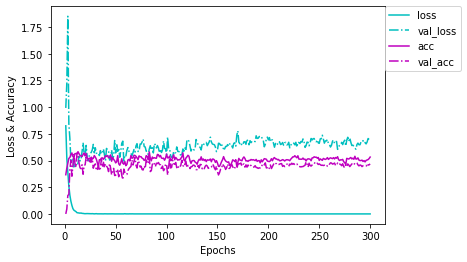

In [ ]:
loss = history.history['loss']
mae = history.history['accuracy']
# mae_history = history.history['y3_accuracy']
val_loss = history.history['val_loss']
val_mae = history.history['val_accuracy']

epochs = range(1,len(loss) +1)
plt.plot(epochs, loss, 'c', label='loss')
plt.plot(epochs, val_loss, 'c-.', label='val_loss')

plt.plot(epochs, mae, 'm', label='acc')
plt.plot(epochs, val_mae, 'm-.', label='val_acc')

plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)

plt.xlabel('Epochs')
plt.ylabel('Loss & Accuracy')
# plt.plot(epochs, mae_history, 'm', label='mae')

# plt.savefig('/content/drive/My Drive/images/3dcnn/3d_loss_acc5.png' ,dpi=800,bbox_inches='tight')

In [ ]:

# 这部分就是各个模型在测试集的表现
newx = test_data 

m1 = model.predict(newx)




In [ ]:

def flatten(data):
  newlist = [item for items in data for item in items]
  for i in range(len(newlist)):
    if newlist[i] >= 0.5:
      newlist[i] = 1
    else:
      newlist[i] = 0
  return newlist



In [ ]:
aaa = flatten(test_label)
bbb = flatten(m1) 
accuracy_score(aaa,bbb)

0.41333333333333333

In [ ]:
# m = model2.predict(train_data[200:201])
tttt = range(499,501)
print(test_label[tttt])
print(m1[tttt])
# print(m5[tttt])
# print(m)

[[1. 0. 1. 0.]
 [1. 0. 1. 0.]]
[[2.6157836e-04 9.9997008e-01 2.4867118e-03 9.7923172e-01]
 [1.2561056e-01 7.0283854e-01 6.6729975e-01 5.5534679e-01]]


In [ ]:
# r = r2_score(test_label, m/100, multioutput='raw_values')
# r11 = r2_score(train_label, model.predict(train_data), multioutput='raw_values')
r112 = r2_score(test_label, model.predict(test_data), multioutput='raw_values')
# r22 = r2_score(test_label, m2/100, multioutput='raw_values')
# r22 = r2_score(train_label, model2.predict(train_data), multioutput='raw_values')
# r33 = r2_score(train_label, model3.predict(train_data), multioutput='raw_values')
# r44 = r2_score(train_label, model4.predict(train_data), multioutput='raw_values')
# r55 = r2_score(train_label, model5.predict(train_data), multioutput='raw_values')
# print("training r2",r11)
print("testing r2",r112)
# print(r22)
# print(r33)
# print(r44)
# print(r55)
# print(r2)

In [ ]:
def calculate_mse(predict):   #对比三种视觉情况 每个model的mse  
  nums = 600 #测试集数量
  y_data_c1 = test_label[:,0] 
  y_data_c2 = test_label[:,1] 
  # y_data_c3 = test_label[:,2] 
  y_predict1_c1 = predict[:,0]/100
  y_predict1_c2 = predict[:,1]/100
  # y_predict1_c3 = predict[:,2]/100
  tmp1 = 0
  tmp2 = 0
  tmp3 = 0
  for i in range(nums):
    tmp1 = tmp1 + (y_data_c1[i]- y_predict1_c1[i])**2
    tmp2 = tmp2 + (y_data_c2[i]- y_predict1_c2[i])**2
    # tmp3 = tmp3 + (y_data_c3[i]- y_predict1_c3[i])**2
  c1 = tmp1/nums
  c2 = tmp2/nums
  # c3 = tmp3/nums
  # c1 = K.mean(K.square( y_data_c1- y_predict1_c1), axis=-1)
  # c2 = K.mean(K.square( y_data_c2- y_predict1_c2), axis=-1)
  # c3 = K.mean(K.square( y_data_c3- y_predict1_c3), axis=-1)
  return c1, c2 
# Model = calculate_mse(m)
Model1 = calculate_mse(m1)
# Model2 = calculate_mse(m2)
# Model3 = calculate_mse(m3)
# Model4 = calculate_mse(m4)
# Model5 = calculate_mse(m5)

# print(Model)
print(Model1)
# print(Model2)
# print(Model3)
# print(Model4)
# print(Model5)

(0.013625092833898692, 0.0159671984265448)


# 测试结果

In [ ]:
tm = model.predict(test_data)   #预测测试集label

num = 600
for i in range(num): #将测试集预测label转化为0,1
  for j in range(4):
    if tm[i,j]>= 0.5:
      tm[i,j] = 1
    if tm[i,j]<0.5:
      tm[i,j] = 0
print(tm[145:155])

Test_label = np.zeros((num,4))  #将测试集真实label放进array
for i in range(num):
  for j in range(4):
    Test_label[i,j] = test_label[i,j]


[[0. 1. 0. 1.]
 [0. 1. 0. 1.]
 [0. 0. 1. 1.]
 [0. 1. 1. 1.]
 [1. 1. 1. 0.]
 [0. 1. 0. 1.]
 [0. 1. 0. 1.]
 [0. 1. 1. 0.]
 [0. 1. 0. 1.]
 [0. 1. 0. 0.]]


In [ ]:

ttt = accuracy_score(Test_label.reshape([num*4]),tm.reshape([num*4]))
print(ttt)


0.43472222222222223


In [ ]:
test = model.evaluate(test_data, [test_label[:,0],test_label[:,1],test_label[:,2],test_label[:,3]
                                  # ,test_label[:,4] ,test_label[:,5],test_label[:,6],test_label[:,7],
                                #  test_label[:,8],test_label[:,9],test_label[:,10],test_label[:,11],test_label[:,12],test_label[:,13],test_label[:,14],test_label[:,15]
                                #   ,test_label[:,16],test_label[:,17],test_label[:,18],test_label[:,19],test_label[:,20],test_label[:,21],test_label[:,22],test_label[:,23],
                                #  test_label[:,24]
                                  ], verbose=0)
# print(test)
average = 5
mean = np.mean(test[average:])
print(len(test[average:]))

print(mean)

4
0.4125000014901161


In [ ]:
model.predict(test_data[899:900])

[array([[1.0000000e+00, 2.8864263e-25, 2.0647243e-11]], dtype=float32),
 array([[1.9982869e-17, 3.2378728e-20, 1.0000000e+00]], dtype=float32),
 array([[1.0000000e+00, 8.8592655e-10, 3.5325257e-10]], dtype=float32),
 array([[4.779138e-08, 8.480343e-18, 1.000000e+00]], dtype=float32)]

In [ ]:
print(test_label[899:900])

[[[0 0 1]
  [1 0 0]
  [0 0 1]
  [1 0 0]]]


# 参考模型

In [ ]:
def Functional_model():
  initializer = tf.keras.initializers.he_normal
  model = Sequential()
  model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', kernel_initializer=initializer, input_shape=(30,116,116, 1)))
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer=initializer))
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  model.add(BatchNormalization()) 
  model.add(Dropout(0.5))
  model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer=initializer))
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  # model.add(Conv3D(32, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
  # model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.5))
  model.add(Flatten())
  # model.add(Dense(3200, activation='relu', kernel_initializer='he_uniform'))
  # model.add(Dense(1600, activation='relu', kernel_initializer='he_uniform'))
  # model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(1024, activation='relu', kernel_initializer=initializer))
  # model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(4, activation='sigmoid'))
  model.summary()
  from keras.optimizers import RMSprop,Adam,SGD
  model.compile(optimizer = Adam(learning_rate=0.00005),
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  return model


